In [32]:
import autograd.numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline 
from scipy.sparse import hstack 
from sklearn.linear_model import LogisticRegression 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score,  roc_curve, auc, accuracy_score
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay
from itertools import cycle
import string
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA 
from sklearn.metrics import rand_score, adjusted_rand_score
import copy


<font size = '5'>Reading the Training and the Test Files

<font size = '3'>For feature engineering, I decided to work with 4 sets of columns from the data to preprocess for features: ;review', 'summary', 'verified', and 'votes'. I started with just the 'review' and 'summary' columns, but after playing around with the other columns, the latter two seemed to improve the overall performance of the model. I believe this is so because verification filters out the a few spam reviews vs genuine ones whereas the votes on every review reflect if how common that belief is among the customers, or how much they agree with it.  

In [ ]:
train= pd.read_csv('Training.csv')
review_train = train['reviewText']
summary_train= train['summary'].fillna('') #fillna replaces the nan values with empty spaces 
verified_train = train['verified'].astype(str)
votes_train = train['vote'].astype(str)

Test = pd.read_csv('Test.csv')
review_test = Test['reviewText']
summary_test = Test['summary'].fillna('')
verified_test = Test['verified'].astype(str)
votes_test = Test['vote'].astype(str)


I added additional steps for preprocessing the text data by converting all words to lowercase and removing punctuation. 

In [3]:

def remove_punctuation(text):
    text = text.lower()
    return text.translate(str.maketrans('', '', string.punctuation))

<font size = '5'>Vectorizing the training and testing datasets\
<font size ='3'> I use Count Vectorizer for Bernoulli and TFID vectorizer for logistic. This is mainly to accomodate the vectorized data to all the models used: the Bernoulli Naive Bayes model, which models the probability of presence or absence of features, works best with count vectorizer. Due to this, the data vectorized using Count Vectorizer resulted in a higher overall score as compared to TFID vectorizer. 

In [31]:
def vectorize(vectorizer): 
    global review_train,summary_train, review_test, summary_test

    
    vectorizer_review = copy.deepcopy(vectorizer)
    vectorizer_summary = copy.deepcopy(vectorizer)

    review_train_number = vectorizer_review.fit_transform(review_train )
    summary_train_number  = vectorizer_summary.fit_transform(summary_train)

    review_test_number = vectorizer_review.transform(review_test)
    summary_test_number = vectorizer_summary.transform(summary_test)

    combined_train = hstack((review_train_number, summary_train_number))
    combined_test = hstack((review_test_number, summary_test_number ))


    print("Sanity Check :" )
    print(f"Shape of Training feature space: {combined_train.shape}")
    print(f"Shape of Test feature space: {combined_test.shape}")
    return combined_train, combined_test


In [5]:
Binary_Split = {'1' : train['overall'].replace({1:0, 2:1, 3:1, 4:1, 5:1}), 
          '2' : train['overall'].replace({1:0, 2:0, 3:1, 4:1, 5:1}) ,
          '3' : train['overall'].replace({1:0, 2:0, 3:0, 4:1, 5:1}),
          '4' : train['overall'].replace({1:0, 2:0, 3:0, 4:0, 5:1})}

<font size = '6'>Classifiers:\
<font size = '4'>
1. Logistic Regression: Logistic was an obvious choice for several reasons. Firstly, it was fast, and performed the best out of all the models (6-7) I experimented with. Additionally, it was also the I was most familiar as we learned about it in the class. 

2. Multinomial Naive Bayes: We briefly discussed different types of Naive Bayes model in class, which motivated me to try it out. As compared to other models (random forests, decision trees etc.), MNB was much faster and consistently gave me better results. 

3. Bernoulli Naive Bayes: I chose Bernoulli NB for similar reasons as MNB; it was extremely fast and consistent. 

Overall choosing these three models not only gave me better average resuls, but also made it much more convenient to debug and optimize because of how fast they were. 

In [13]:
logistic_regression = LogisticRegression(solver = 'liblinear')
MNB = MultinomialNB()
BNB = BernoulliNB()

<font size = "6">Logistic Regression 

<font size = '3'>For all of my classification models, I hyperparameter-tune them using the GridSearchCV from scikit library. I chose the hyperparameters that I was familiar with or understood the best  after reading the documentation. Here, I choose relatively small values of 'C' which is the inverse of regularization strength. Lower values of C indicate stronger regularization which is useful to prevent against overfitting. While I also experimented with scaling the data, I did not see any significant improvements after scaling so I removed it reduce complexity of the overall training process. Overall, the logistic regression model displayed performance significantly above the required threshold following the hyperparameter tuning. 



Sanity Check :
Shape of Training feature space: (29189, 14016)
Shape of Test feature space: (4500, 14016)


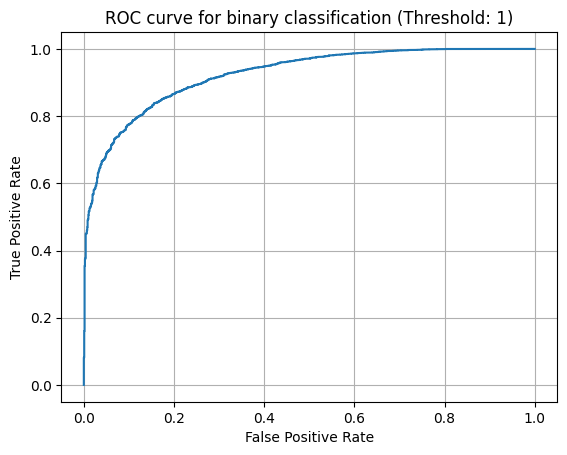

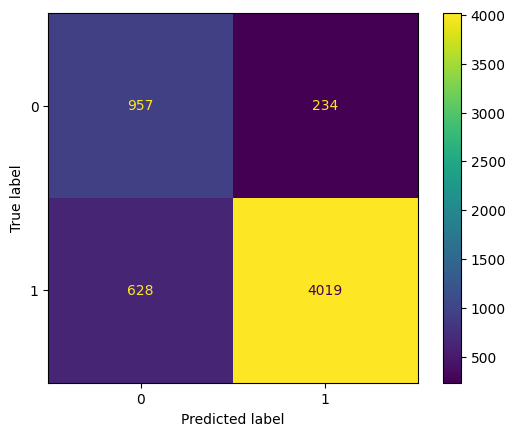

The best hyperparameters for logistic regression with cutoff 1  are {'C': 1, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l2'} with cross validation score of 0.7953328301381267
The AUC score for this model is: 0.9232599889747672
The f1 macro score for this model is: 0.7963136677136289
The accuracy score for this model is: 0.8523466940733128
__________________________________________________________________________________________________________________



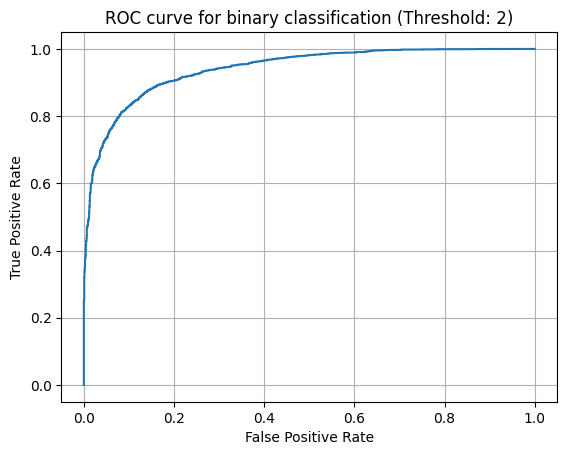

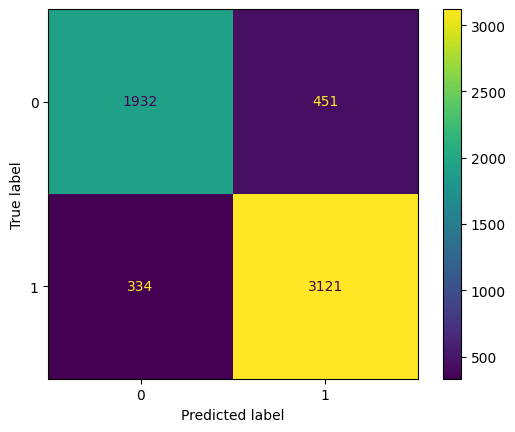

The best hyperparameters for logistic regression with cutoff 2  are {'C': 1, 'class_weight': None, 'max_iter': 500, 'penalty': 'l2'} with cross validation score of 0.8479087849303362
The AUC score for this model is: 0.9406406814307569
The f1 macro score for this model is: 0.8597172574958469
The accuracy score for this model is: 0.8655361425145598
__________________________________________________________________________________________________________________



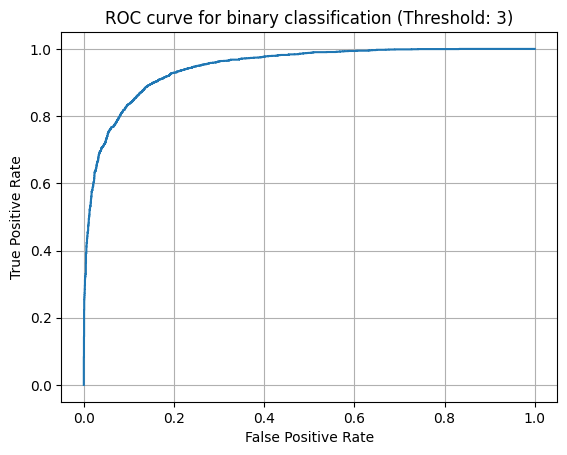

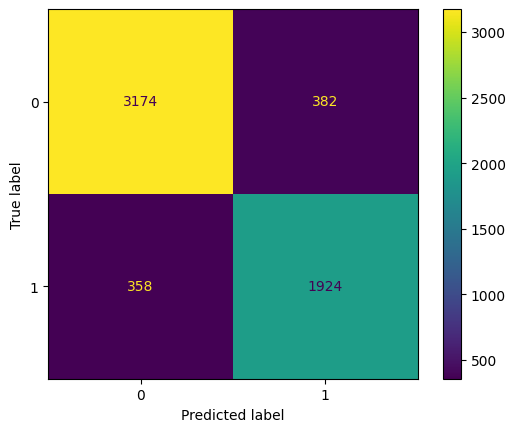

The best hyperparameters for logistic regression with cutoff 3  are {'C': 1, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l2'} with cross validation score of 0.8679688316766772
The AUC score for this model is: 0.9465758333670166
The f1 macro score for this model is: 0.8671539357751402
The accuracy score for this model is: 0.8732442617334704
__________________________________________________________________________________________________________________



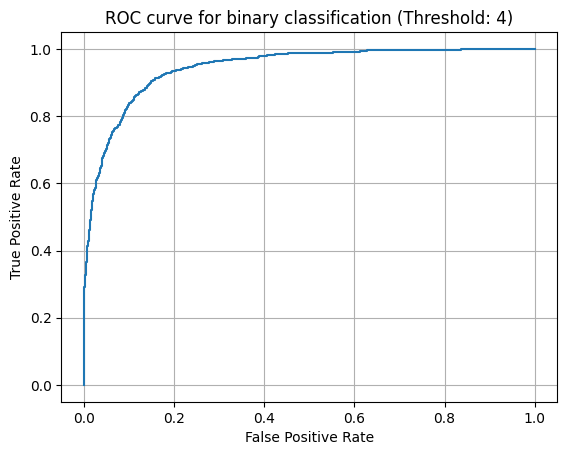

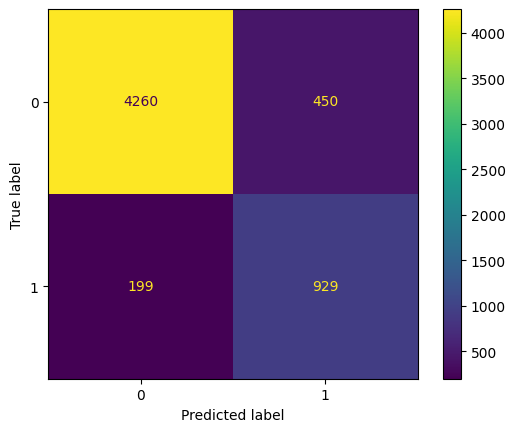

The best hyperparameters for logistic regression with cutoff 4  are {'C': 1, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l2'} with cross validation score of 0.8268516362258724
The AUC score for this model is: 0.9444397388986764
The f1 macro score for this model is: 0.8351714338254023
The accuracy score for this model is: 0.8888317917094896
__________________________________________________________________________________________________________________



In [33]:
log_vectors = vectorize(TfidfVectorizer( ngram_range =(1,2), max_features=10000 , max_df = 0.7, min_df = 6, preprocessor=remove_punctuation))
combined_train_log,  combined_test_log = log_vectors[0], log_vectors[1]

param_grid_log = {

    'max_iter':[500],
    'C': [0.01, 0.05, 0.1, 0.2, 0.5, 1, 2], 
    'class_weight':['balanced', None],
    'penalty':['l2' ]

}

for name, y_split  in Binary_Split.items():

    X_train, X_test, y_train, y_test = train_test_split(combined_train_log, y_split, test_size= 0.2, stratify = y_split)


    gridlog = GridSearchCV(logistic_regression,param_grid = param_grid_log, scoring = 'f1_macro', cv = 5)
    gridlog.fit(X_train,y_train )

    
    Probabilities = gridlog.predict_proba(X_test)
    y_pred = gridlog.predict(X_test)
    auc_score = float(roc_auc_score(y_test, Probabilities[:, 1]))
    macro_f1 = f1_score(y_test, y_pred, average  ='macro') 
    accuracy = accuracy_score(y_test,y_pred)

    #plotting the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, Probabilities[:, 1] )
    plt.plot(fpr, tpr) 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC curve for binary classification (Threshold: {name})')
    plt.grid()

    #Displaying the confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=gridlog.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                   display_labels=gridlog.classes_)
    disp.plot()
    plt.show()

    print(f"The best hyperparameters for logistic regression with cutoff {name}  are {gridlog.best_params_} with cross validation score of {gridlog.best_score_}")
    print(f"The AUC score for this model is: {auc_score}")
    print(f"The f1 macro score for this model is: {macro_f1}")
    print(f"The accuracy score for this model is: {accuracy}")
    print("__________________________________________________________________________________________________________________", end="\n\n")


    test = gridlog.predict(combined_test_log)
    test_ids = Test.index
    test_submission = pd.DataFrame({'id':test_ids, f'binary_split_{name}':test})
    test_submission.to_csv(f'test_submission_part_{name}.csv', index= False)
    


<font size = '5'> Multinomial NB \
<font size = '3'> With MNB, the only hyperparamaters I tune are 'alpha' and 'fit prior'. By default, MNB offers less parameters to experiment with. Out of the available ones, 'alpha' or the smoothing parameter was the most significant as it helps deal with sparse data and cases of zero probabilities which is the case here. I experiement with a large number of alpha values because of how fast and efficient the MNB model is for tasks like this(text calssification). 

Sanity Check :
Shape of Training feature space: (29189, 14016)
Shape of Test feature space: (4500, 14016)


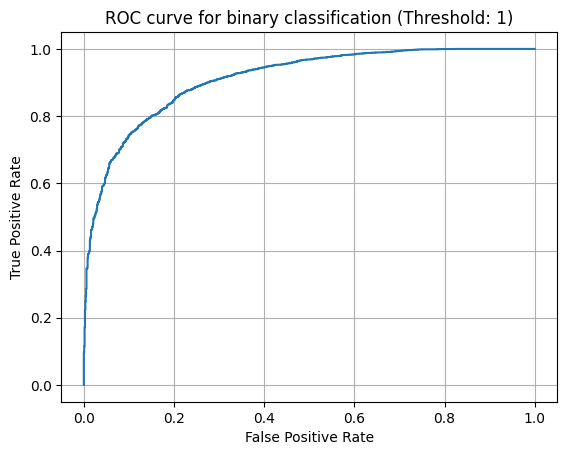

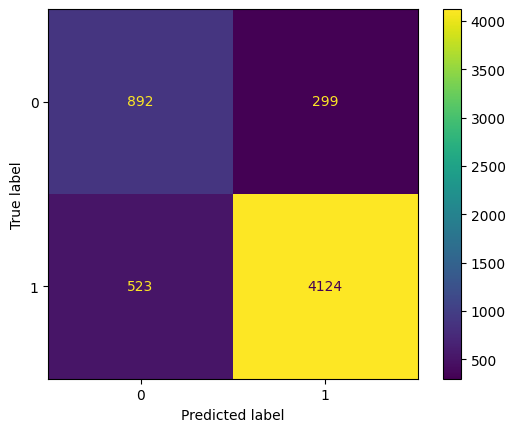

The best hyperparameters for Multinomial Naive Bayes with cutoff 1  are {'alpha': 2, 'fit_prior': False} with cross validation score of 0.7872375619271678
The AUC score for this model is: 0.9113258339345536
The f1 macro score for this model is: 0.7969728072186905
The accuracy score for this model is: 0.8591983556012333

__________________________________________________________________________________________________________

(4500, 2)


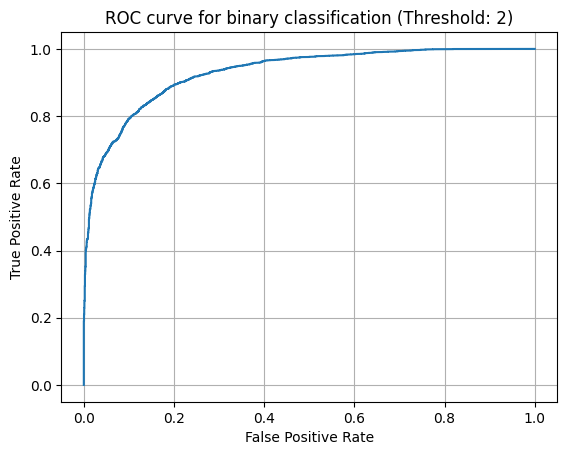

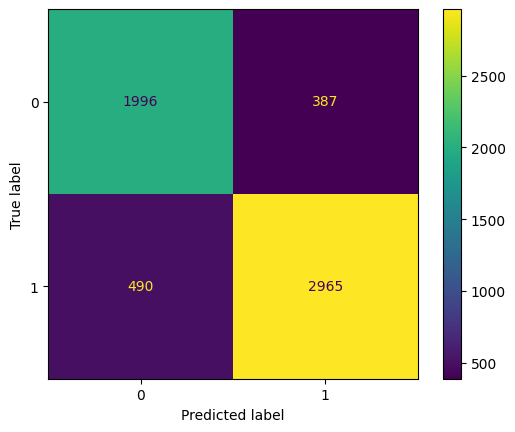

The best hyperparameters for Multinomial Naive Bayes with cutoff 2  are {'alpha': 3, 'fit_prior': False} with cross validation score of 0.8456643202708983
The AUC score for this model is: 0.930244441300019
The f1 macro score for this model is: 0.845521459054011
The accuracy score for this model is: 0.8497773210003425

__________________________________________________________________________________________________________

(4500, 2)


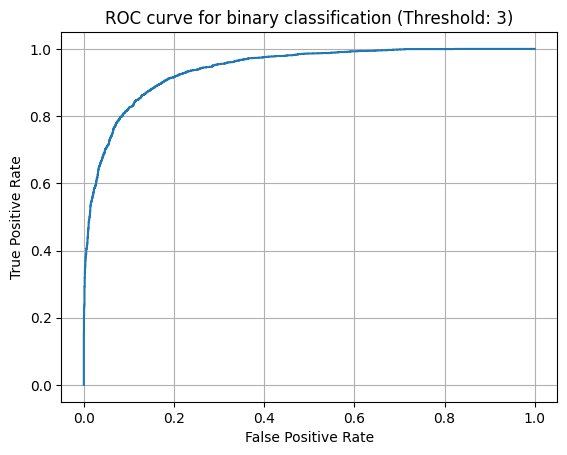

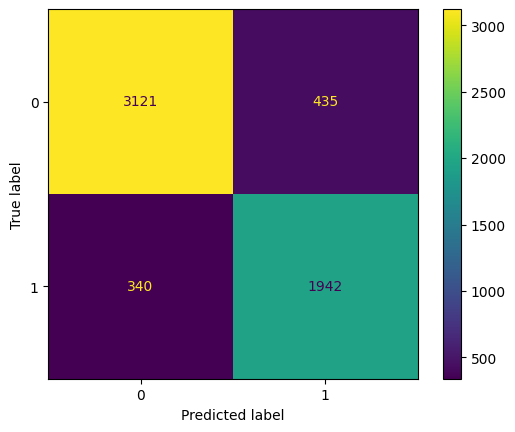

The best hyperparameters for Multinomial Naive Bayes with cutoff 3  are {'alpha': 1, 'fit_prior': False} with cross validation score of 0.8640174867555706
The AUC score for this model is: 0.941602323263492
The f1 macro score for this model is: 0.8616046156326633
The accuracy score for this model is: 0.8672490578965399

__________________________________________________________________________________________________________

(4500, 2)


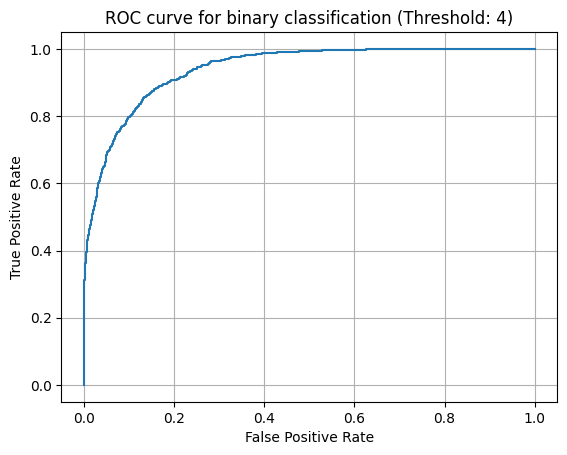

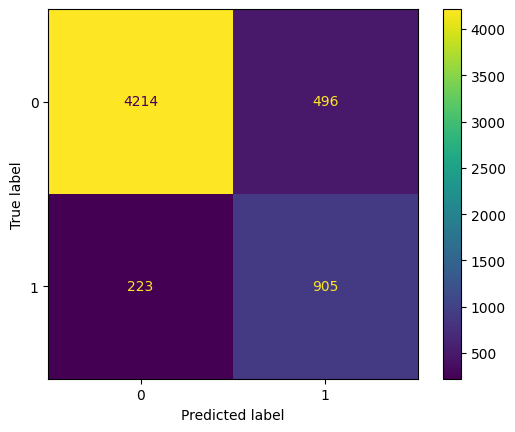

The best hyperparameters for Multinomial Naive Bayes with cutoff 4  are {'alpha': 1, 'fit_prior': False} with cross validation score of 0.8187537286834609
The AUC score for this model is: 0.9403976750839468
The f1 macro score for this model is: 0.8185464486019245
The accuracy score for this model is: 0.8768413840356286

__________________________________________________________________________________________________________

(4500, 2)


In [35]:
MNB_vectors = vectorize(TfidfVectorizer( ngram_range =(1,2), max_features=10000 , max_df = 0.7, min_df = 6, preprocessor=remove_punctuation))
combined_train_MNB,  combined_test_MNB = MNB_vectors[0], MNB_vectors[1]

param_grid_MNB = {

    'alpha':[0.1, 0.5, 0.8, 1, 2,3 ,4 , 5, 6 ],
    'fit_prior': [True, False]
}

for name, y_split  in Binary_Split.items():

    X_train, X_test, y_train, y_test = train_test_split(combined_train_MNB, y_split, test_size= 0.2, stratify = y_split)


    gridMNB = GridSearchCV(MNB,param_grid = param_grid_MNB, scoring = 'f1_macro', cv = 5)
    gridMNB.fit(X_train,y_train )
    
    Probabilities = gridMNB.predict_proba(X_test)
    y_pred = gridMNB.predict(X_test)
    auc_score = float(roc_auc_score(y_test, Probabilities[:, 1]))
    macro_f1 = f1_score(y_test, y_pred, average  ='macro') 
    accuracy = accuracy_score(y_test,y_pred)

    #plotting the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, Probabilities[:, 1] )
    plt.plot(fpr, tpr) 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC curve for binary classification (Threshold: {name})')
    plt.grid()

    #Displaying the confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=gridMNB.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                   display_labels=gridMNB.classes_)
    disp.plot()
    plt.show()

    print(f"The best hyperparameters for Multinomial Naive Bayes with cutoff {name}  are {gridMNB.best_params_} with cross validation score of {gridMNB.best_score_}")
    print(f"The AUC score for this model is: {auc_score}")
    print(f"The f1 macro score for this model is: {macro_f1}")
    
    print(f"The accuracy score for this model is: {accuracy}", end="\n\n")
    print("__________________________________________________________________________________________________________", end = '\n\n')


    test = gridMNB.predict(combined_test_MNB)   
    test_ids = Test.index
    test_submission = pd.DataFrame({'id':test_ids, f'binary_split_{name}':test})
    print(test_submission.shape)
    test_submission.head()
    test_submission.to_csv(f'test_submission_part_{name}.csv', index= False)
    


<font size = '6'> Bernoulli Naive Bayes Classifier\
<font size = '3'>  I tune the same parameters for BNB as I did for MNB. However, as it fundamentally works diffently as compared to MNB in terms of the assumptions it makes about the data, it gives different results. As stated earlier, I vectorize my data using Count Vectorizer to accomodate all the models. 

Sanity Check :
Shape of Training feature space: (29189, 14016)
Shape of Test feature space: (4500, 14016)


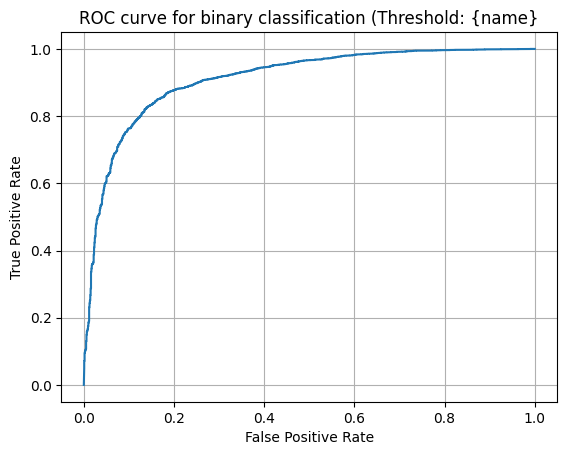

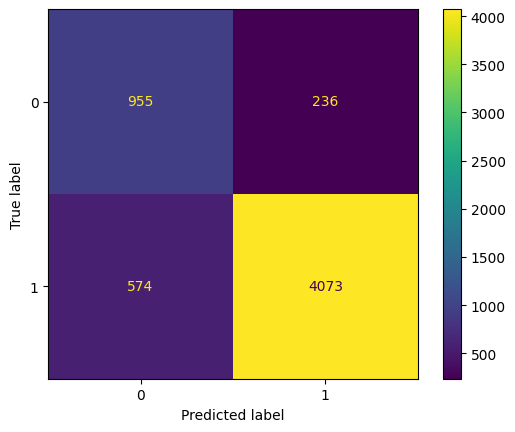

The best hyperparameters for Bernoulli Naive Bayes with cutoff 1  are {'alpha': 2, 'fit_prior': True} with cross-validation score of 0.7923409613274467
The AUC score for this model is: 0.9109614881137258
The f1 macro score for this model is: 0.80588186033681
The accuracy score for this model is: 0.8612538540596094

__________________________________________________________________________________________________________________________

(4500, 2)


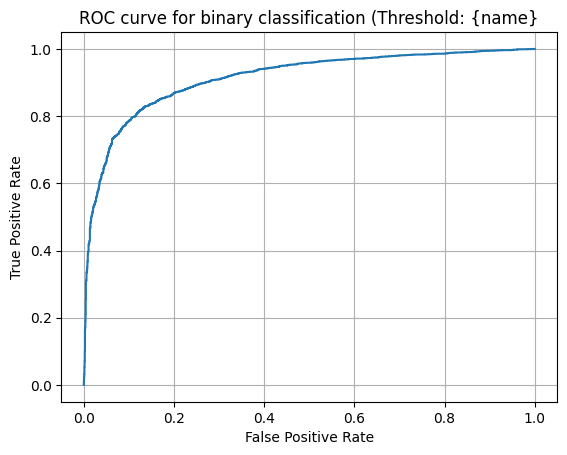

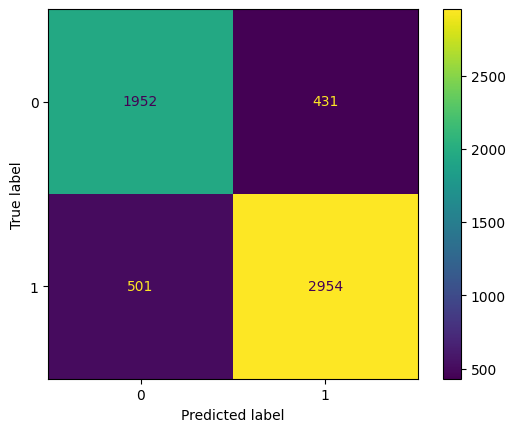

The best hyperparameters for Bernoulli Naive Bayes with cutoff 2  are {'alpha': 0.1, 'fit_prior': False} with cross-validation score of 0.8356466450967227
The AUC score for this model is: 0.9135219745750927
The f1 macro score for this model is: 0.8355107164105466
The accuracy score for this model is: 0.8403562863994518

__________________________________________________________________________________________________________________________

(4500, 2)


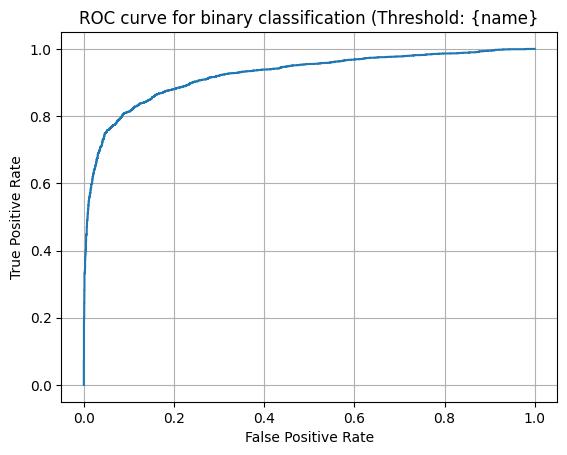

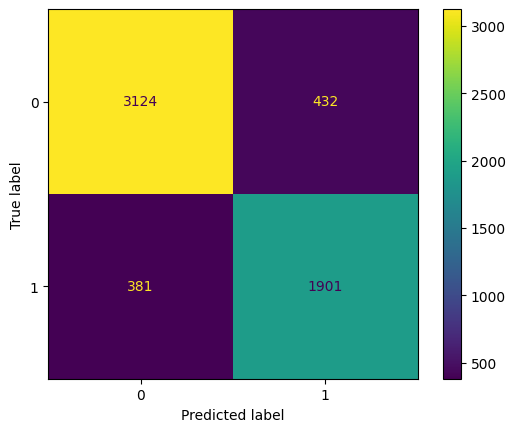

The best hyperparameters for Bernoulli Naive Bayes with cutoff 3  are {'alpha': 6, 'fit_prior': True} with cross-validation score of 0.848768892318302
The AUC score for this model is: 0.9236599040369733
The f1 macro score for this model is: 0.854347910477693
The accuracy score for this model is: 0.8607399794450155

__________________________________________________________________________________________________________________________

(4500, 2)


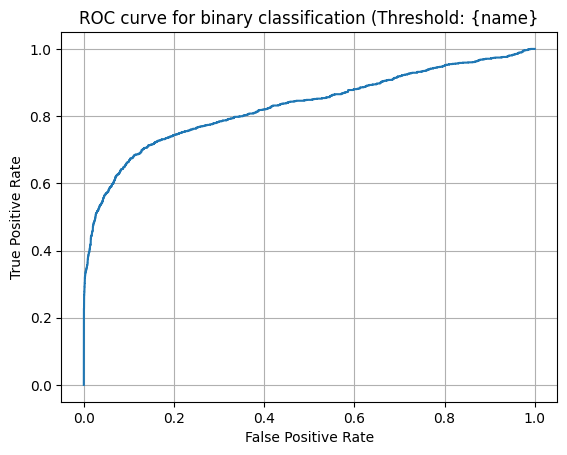

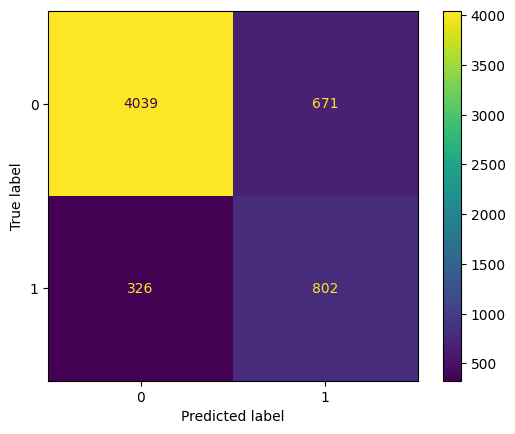

The best hyperparameters for Bernoulli Naive Bayes with cutoff 4  are {'alpha': 6, 'fit_prior': True} with cross-validation score of 0.7974711337842215
The AUC score for this model is: 0.829690299799732
The f1 macro score for this model is: 0.7534118155445617
The accuracy score for this model is: 0.829222336416581

__________________________________________________________________________________________________________________________

(4500, 2)


In [37]:
BNB_vectors = vectorize(CountVectorizer( ngram_range =(1,2), max_features=10000 , max_df = 0.7, min_df = 6, preprocessor=remove_punctuation, binary = True))
combined_train_BNB,  combined_test_BNB = BNB_vectors[0], BNB_vectors[1]

param_grid_BNB = {

    'alpha':[0.01, 0.1, 0.2, 0.5,0.6, 0.7, 0.8, 0.9, 1, 2, 4, 5, 6],
    'fit_prior': [True, False]
}

for name, y_split  in Binary_Split.items():

    X_train, X_test, y_train, y_test = train_test_split(combined_train_BNB, y_split, test_size= 0.2, stratify = y_split)


    gridBNB = GridSearchCV(BNB,param_grid = param_grid_BNB, scoring = 'f1_macro', cv = 5)
    gridBNB.fit(X_train,y_train )
    
    Probabilities = gridBNB.predict_proba(X_test)
    y_pred = gridBNB.predict(X_test)
    auc_score = float(roc_auc_score(y_test, Probabilities[:, 1]))
    macro_f1 = f1_score(y_test, y_pred, average  ='macro') 
    accuracy = accuracy_score(y_test,y_pred)

    #plotting the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, Probabilities[:, 1] )
    plt.plot(fpr, tpr) 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve for binary classification (Threshold: {name}')
    plt.grid()

    #Displaying the confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=gridBNB.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                   display_labels=gridBNB.classes_)
    disp.plot()
    plt.show()

    print(f"The best hyperparameters for Bernoulli Naive Bayes with cutoff {name}  are {gridBNB.best_params_} with cross-validation score of {gridBNB.best_score_}")
    print(f"The AUC score for this model is: {auc_score}")
    print(f"The f1 macro score for this model is: {macro_f1}")
    print(f"The accuracy score for this model is: {accuracy}", end="\n\n")

    print("__________________________________________________________________________________________________________________________", end = '\n\n')


    test = gridBNB.predict(combined_test_BNB)   
    test_ids = Test.index
    test_submission = pd.DataFrame({'id':test_ids, f'binary_split_{name}':test})
    print(test_submission.shape)
    test_submission.head()
    test_submission.to_csv(f'test_submission_part_{name}.csv', index= False)
    


<font size = '8'> Multiclass Classification

The best hyperparameters for Multinomial Naive Bayes are {'alpha': 6, 'fit_prior': True}
The best scores for Multinomial Naive Bayes is 0.5943093628005433


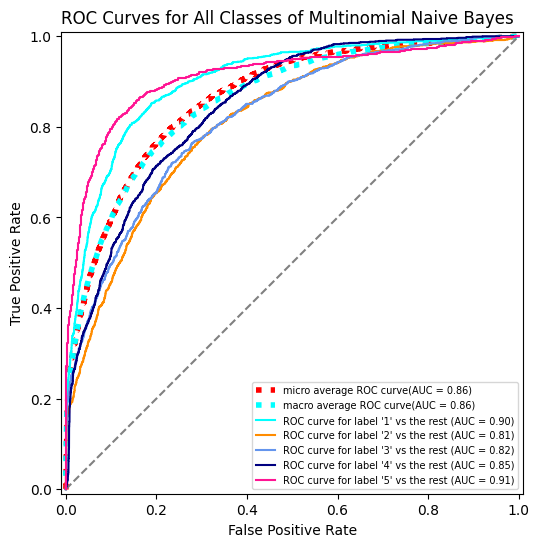

 The confusion matrix for Multinomial Naive Bayes :


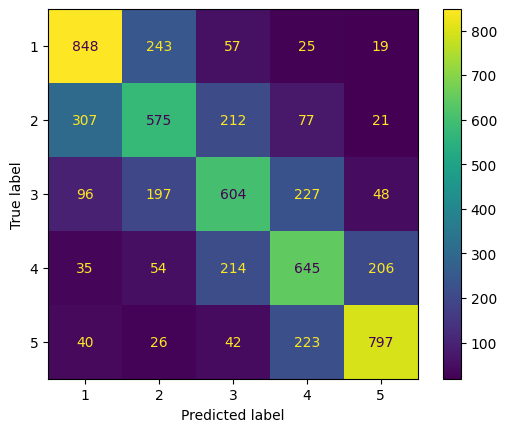

The average macro AUC score for this model is: 0.8580873988998635
The average micro AUC score for this model is: 0.8639159183591315
The average F1 macro score for this model is: 0.5936851996654277
The accuracy score for this model is: 0.5942103460089072
___________________________________________________________________________________________________________________________________________

The best hyperparameters for Bernoulli Naive Bayes are {'alpha': 0.01, 'fit_prior': True}
The best scores for Bernoulli Naive Bayes is 0.5011149209926411


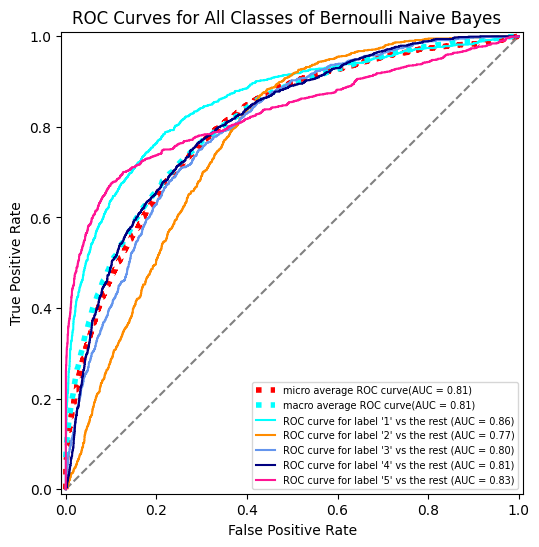

 The confusion matrix for Bernoulli Naive Bayes :


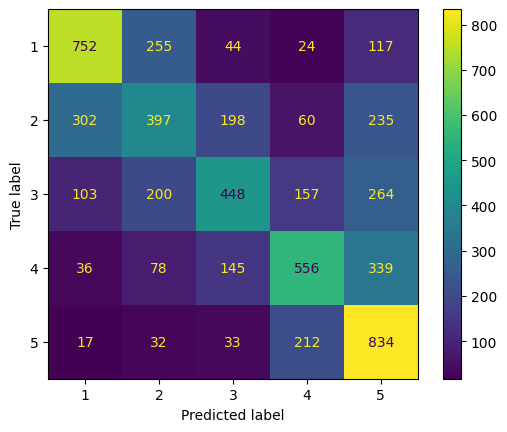

The average macro AUC score for this model is: 0.8124834403348372
The average micro AUC score for this model is: 0.8052976756753458
The average F1 macro score for this model is: 0.5039796484530351
The accuracy score for this model is: 0.5116478245974649
___________________________________________________________________________________________________________________________________________

The best hyperparameters for Logistic Regression are {'C': 0.1, 'class_weight': None, 'max_iter': 500, 'penalty': 'l2'}
The best scores for Logistic Regression is 0.5851788496367145


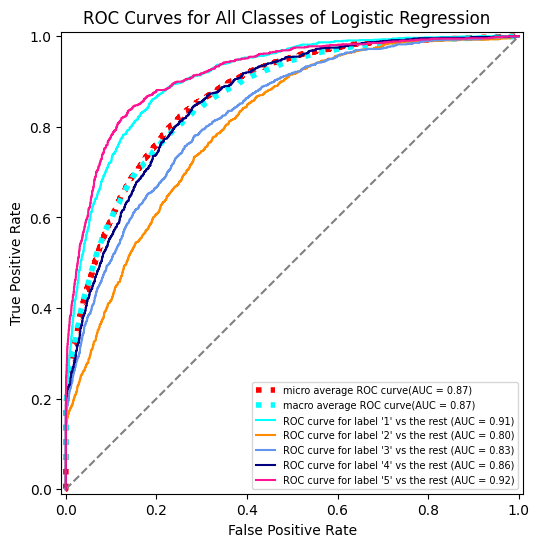

 The confusion matrix for Logistic Regression :


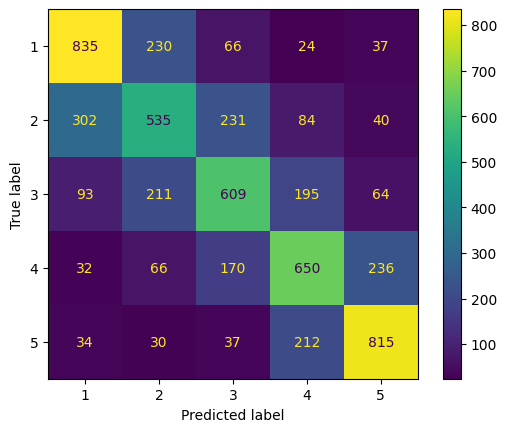

The average macro AUC score for this model is: 0.8652637502629806
The average micro AUC score for this model is: 0.8700927013491248
The average F1 macro score for this model is: 0.5880101896021916
The accuracy score for this model is: 0.5899280575539568
___________________________________________________________________________________________________________________________________________



In [10]:

Y = train['overall'].copy()


param_grid_list = [ param_grid_MNB, param_grid_BNB, param_grid_log]
models = [ MNB,  BNB, logistic_regression]
model_names = ['Multinomial Naive Bayes', 'Bernoulli Naive Bayes', 'Logistic Regression' ]

# Logistic Regression','logreg',LogisticRegression(solver = 'liblinear'),param_grid_log,


for i, model  in enumerate(models):

    X_train, X_test, y_train, y_test = train_test_split(combined_train, Y, test_size= 0.2, stratify = Y)
    grid = GridSearchCV(model, param_grid = param_grid_list[i], scoring = 'f1_macro',cv = 5)
    grid.fit(X_train,y_train)


    print(f"The best hyperparameters for {model_names[i]} are {grid.best_params_}")
    print(f"The best scores for {model_names[i]} is {grid.best_score_}")

    #predicting 
    Probabilities = grid.predict_proba(X_test)
    y_pred = grid.predict(X_test)



# Finding ROC, and AUC (average macro and micro) values
    label_binarizer = LabelBinarizer().fit(y_train)
    y_onehot_test = label_binarizer.transform(y_test)
    y_onehot_pred = label_binarizer.transform(y_pred)
    fpr, tpr, roc_auc = {}, {}, {}

    #Finding the average micro AUC score
    fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), Probabilities.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    #Finding the average macro AUC score
    for j in range(5): 
        fpr[j], tpr[j], _ = roc_curve(y_onehot_test[:, j], Probabilities[:, j])
        roc_auc[j] = auc(fpr[j], tpr[j])

    fpr_grid = np.linspace(0.0, 1.0, 1000)
    mean_tpr = np.zeros_like(fpr_grid)

    for k in range(5): 
        mean_tpr += np.interp(fpr_grid, fpr[k], tpr[k])
        
    mean_tpr /= 5
    
    fpr["macro"] = fpr_grid
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    #Plotting the average(micro and macro) ROC  alonf with ROC curves for individual classes  
    fig, ax = plt.subplots(figsize = (6,6))
    
    #Micro ROC curve 
    plt.plot(
        fpr["micro"], 
        tpr["micro"], 
        label = f"micro average ROC curve(AUC = {roc_auc['micro']:.2f})",
        color = "red",
        linestyle = ":",
        linewidth = 4,
    )
    #Macro ROC curve 
    plt.plot(
        fpr["macro"], 
        tpr["macro"], 
        label = f"macro average ROC curve(AUC = {roc_auc['micro']:.2f})",
        color = "cyan",
        linestyle = ":",
        linewidth = 4,
    )
    plt.plot([0,1], [0, 1], linestyle ="--", color = 'grey')

    #plotting ROC curves individual classes 
    classes = [1,2,3,4,5]
    colors = cycle(["aqua", "darkorange", "cornflowerblue", "navy", "deeppink"])
    for l, color in zip(classes, colors): 
        fpr[l], tpr[l], _ = roc_curve(y_onehot_test[:, l-1], Probabilities[:, l-1])
        display = RocCurveDisplay(fpr = fpr[l], tpr=tpr[l], estimator_name=f"ROC curve for label '{l}' vs the rest (AUC = {auc(fpr[l], tpr[l]):.2f})")
        display.plot(ax=ax, color=color) 
        plt.legend(fontsize = 7 )
    
    ax.set(
        xlabel ="False Positive Rate", 
        ylabel = "True Positive Rate",
        title = f"ROC Curves for All Classes of {model_names[i]}  "
    )
    plt.show()
    
    print(f" The confusion matrix for {model_names[i]} :")

    cm = confusion_matrix(y_test, y_pred, labels=grid.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                   display_labels=grid.classes_)
    disp.plot()
    plt.show()

    macro_f1 = f1_score(y_test, y_pred, average = 'macro')
    accuracy = accuracy_score(y_test, y_pred)


    print(f"The average macro AUC score for this model is: {roc_auc["macro"]}")
    print(f"The average micro AUC score for this model is: {roc_auc["micro"]}")
    print(f"The average F1 macro score for this model is: {macro_f1}")
    print(f"The accuracy score for this model is: {accuracy}")


    # print(f"The f1 macro score for this model is: {macro_f1}")
    print("___________________________________________________________________________________________________________________________________________", end="\n\n")

    test = grid.predict(combined_test)  
    test_ids = Test.index
    test_submission = pd.DataFrame({'id':test_ids, 'labels':test})
    test_submission.head()
    test_submission.to_csv(f'multiclass_model_{i+1}.csv', index= False)

<font size = '6'> Kaggle Scores for Classification Tasks

<font size = '3'>
- Threshold 1: 0.80557 <br>
- Threshold 2: 0.84623 <br>
- Threshold 3: 0.88311 <br>
- Threshold 4: 0.83166 <br>
- Multiclass : 0.61134
<br><br>
______________________________________________________________________________________________________________________________________________________________________

<font size = '6'> Clustering

<font size = '3'> Thrhough experimentation, I found out that Count Vectorizer is not an optimal feature extraction method for clustering as information about the frequency of the words/features is removed. The transformed feature space is a sparse matrix full of 0s and 1s, which could lead to poor seperations of cluster. Hence, I transform the raw data again using TFID holds more information through real, continuous number between 0 and 1. Hence, my assumption  was that it would lead to better clustering, which was supported by the result. 

In [ ]:
vectorizer_review_cluster = TfidfVectorizer( ngram_range =(1,2), max_features=10000 , max_df = 0.7, min_df = 6, preprocessor=remove_punctuation)
vectorizer_summary_cluster = TfidfVectorizer( ngram_range =(1,2), max_df = 0.7, max_features = 2500, min_df = 6, preprocessor=remove_punctuation)

review_train_cluster = vectorizer_review_cluster.fit_transform(review_train)
summary_train_cluster = vectorizer_summary_cluster.fit_transform(summary_train)

review_test_cluster = vectorizer_review_cluster.transform(review_test)
summary_test_cluster = vectorizer_summary_cluster.transform(summary_test)

combined_test_cluster = hstack((review_test_cluster, summary_test_cluster))

<font size = '4'> I use principle component analysis to significantly reduce the number of dimensions/ features, which helped reduce noise significantly, making the clustering  more efficient and accurate. 

In [12]:
Clustering_data = combined_test_cluster.copy()
pca = PCA(n_components=15)
X_reduced = pca.fit_transform(Clustering_data)
category_numbers = Test['category'].nunique()
kmeans = KMeans(n_clusters = category_numbers, random_state = 0).fit_predict(X_reduced)

silhouette = silhouette_score(X_reduced, kmeans)
rand_ind = rand_score(Test['category'],kmeans )

print(f'The silhouette score is {silhouette}]')
print(f'The random index score is {rand_ind}')

The silhouette score is 0.6806572451706289]
The random index score is 0.40803457558469786
